In [91]:
import qiskit as qsk, numpy as np, matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Resize
from qiskit.quantum_info import SparsePauliOp, Statevector, Clifford, PauliList
from typing import Callable
from functools import lru_cache
from timeit import default_timer as timer

def random_thetas(shape: "shape"):
    possible_theta_values = np.pi / 2 * np.arange(4)
    # print(possible_theta_values)
    # print(shape)
    return np.random.choice(possible_theta_values, shape)

def evolveSPO(op: SparsePauliOp, other: Clifford) -> SparsePauliOp:
    return SparsePauliOp(
        op.paulis.evolve(other)
    )

def img_to_vec(image: torch.Tensor):
    n = int(np.log2(image.shape[0]))  # Image should be a 2^n x 2^n tensor
    # Convert tensor indices from y,x to y0,y1,...,yn-1,x0,x1,...,xn-1
    image = image.reshape([2 for i in range(2*n)])
    # Permute indices from y0,y1,...,yn-1,x0,x1,...,xn-1 to y0,x0,y1,x1,...,yn-1,xn-1
    image = image.permute([i+j for i in range(n) for j in [0, n]])
    vec = image.flatten()
    return np.array([x for x in vec])

def sumZ(n_qubits: int) -> SparsePauliOp:
    return SparsePauliOp.from_sparse_list(
        [("Z", [i], 1) for i in range(n_qubits)],
        num_qubits = n_qubits
    )

mnist_train = MNIST("./data",
                    train= True,
                    transform= ToTensor(),
                    download= True)

def get_image(idx: int, dataset, n_qubits: int):
    image, label = dataset[idx]
    size = 2**n_qubits
    padded_image = torch.zeros([size, size])
    padded_image[:28, :28] = image.squeeze()[:, :]
    return padded_image

def get_index_from_label(
        qc: qsk.QuantumCircuit,
        label,
        starting_index: int = 0,
        reverse_search_order: bool = False
) -> int:
    for i, instruction in enumerate(qc.data[starting_index:]):
        if instruction.label == label: return i + starting_index
    raise ValueError(f"Label {label} not found in circuit")

class ParametricCircuit:
    def __init__(self):
        self.n_parameters: int = None
        self.params_shape: "shape" = None
    
    def __call__(self, thetas: np.ndarray, *args, **kwds) -> qsk.QuantumCircuit:
        pass

class Model:
    def __init__(self,
                 parametric_circuit: ParametricCircuit,
                 encoding: Callable[..., Statevector],
                 observable: SparsePauliOp
                 ):
        self.param_circ = parametric_circuit
        self.enc = encoding
        self.obs = observable
        self.use_inefficient_method: bool = False

    # def inefficient_call(self, thetas: np.ndarray, input) -> float:
    #     psi = self.enc(input)
    #     qc = self.param_circ(thetas)
    #     evolved_psi = psi.evolve(qc)
    #     return evolved_psi.expectation_value(self.obs)

    def __call__(self, thetas: np.ndarray, input) -> float:
        psi = self.enc(input)
        qc = self.param_circ(thetas)
        if self.use_inefficient_method == False:
            evolved_ops = evolveSPO(self.obs, Clifford(qc))
            return psi.expectation_value(evolved_ops)
        else:
            evolved_psi = psi.evolve(qc)
            return evolved_psi.expectation_value(self.obs)
    
    def param_shift_rule_grad(self, thetas: np.ndarray, input, index: tuple[int]) -> float:
        # print(f"Relevant theta = {thetas[index]}")
        thetas[index] += np.pi / 2
        # print(f"Relevant theta = {thetas[index]}")
        value_plus = self.__call__(thetas, input)
        # print(f"Value plus = {value_plus}")
        thetas[index] -= np.pi
        # print(f"Relevant theta = {thetas[index]}")
        value_minus = self.__call__(thetas, input)
        thetas[index] += np.pi/2
        # print(f"Value minus = {value_minus}")
        return (value_plus - value_minus) / 2
    
    def empirical_NTK(self, thetas: np.ndarray, input1, input2) -> float:
        grad = self.param_shift_rule_grad
        # print(
        #     np.array([
        #         self.param_shift_rule_grad(thetas, input1, index) #* grad(thetas, input2, index)
        #         for index in np.ndindex(thetas.shape)
        #     ])
        # )
        return np.sum([
            grad(thetas, input1, index) * grad(thetas, input2, index)
            for index in np.ndindex(thetas.shape)
        ])
    
    def analytic_NTK(self, input1, input2, n_shots):
        return np.mean([
            self.empirical_NTK(random_thetas(self.param_circ.params_shape),
                               input1, input2)
            for _ in range(n_shots)
        ])


class SimpleTestCircuit(ParametricCircuit):
    def __init__(self, n_qubits: int):
        self.n_parameters: int = n_qubits
        self.params_shape: tuple[int] = (n_qubits)
    
    def __call__(self, thetas: np.ndarray) -> qsk.QuantumCircuit:
        qc = qsk.QuantumCircuit(self.n_parameters)
        for i in range(self.n_parameters): qc.rx(thetas[i], i)
        return qc

class ConvolutionalQNN(ParametricCircuit):
    def __init__(self, n_qubits: int, n_layers: int):
        self.qc: qsk.QuantumCircuit = None
        self.n_qubits: int = n_qubits
        self.n_layers: int = n_layers
        self.params_shape: tuple[int] = (4, 5*n_qubits//2 - 4, n_layers)
        self.n_parameters: int = np.prod(self.params_shape)
        self.gate_label: int = 0

        self.cache_heads: dict[str, qsk.QuantumCircuit] = {}
        self.cache_tails: dict[str, qsk.QuantumCircuit] = {}

    def elementary_2_qubit_gate(self, thetas: np.ndarray, qubit1: int, qubit2: int):
        self.qc.rx(thetas[0], qubit1, label= str(self.gate_label))
        self.gate_label +=1

        self.qc.rx(thetas[1], qubit2, label= str(self.gate_label))
        self.gate_label +=1
        
        self.qc.cx(qubit1, qubit2)
        
        self.qc.rz(thetas[2], qubit1, label= str(self.gate_label))
        self.gate_label +=1
        
        self.qc.rz(thetas[3], qubit2, label= str(self.gate_label))
        self.gate_label +=1
    
    def layer(self, thetas: np.ndarray):
        i = 0
        def apply_gate(qubit1: int, qubit2: int):
            nonlocal i
            self.elementary_2_qubit_gate(thetas[:, i], qubit1, qubit2)
            i += 1
        
        def xiyi_gates(central_qubit: int):
            if central_qubit>0: apply_gate(central_qubit-2, central_qubit-1)
            apply_gate(central_qubit, central_qubit+1)
            if central_qubit<self.n_qubits-2: apply_gate(central_qubit+2, central_qubit+3)
        
        def xxyy_gates(lower_qubit: int):
            apply_gate(lower_qubit, lower_qubit+2)
            apply_gate(lower_qubit+1, lower_qubit+3)
        
        for qubit in np.arange(0, self.n_qubits-2, 2):
            xiyi_gates(qubit)
            xxyy_gates(qubit)
        xiyi_gates(self.n_qubits-2)
    
    def __call__(self, thetas):
        self.qc = qsk.QuantumCircuit(self.n_qubits)
        for i in range(self.n_layers):
            self.layer(thetas[:,:,i])
            self.qc.barrier()
        return self.qc
    
    def cache_circuit_segments(self):
        for i in range(self.n_parameters):
            index = get_index_from_label(self.qc, str(i), i)

            head = qsk.QuantumCircuit(self.n_qubits)
            tail = qsk.QuantumCircuit(self.n_qubits)
            
            head.data = self.qc.data[:index]
            tail.data = self.qc.data[index+1:]
            
            self.cache_heads[str(i)] = Clifford(head)
            self.cache_tails[str(i)] = Clifford(tail)


In [92]:
# Building a circuit-representing tableau from cached single-gate-tableaus

n_qubits = 10

@lru_cache(maxsize=None)
def clifford_RX(integer_angle: int, qubit: int, n_qubits: int):
    qc = qsk.QuantumCircuit(n_qubits)
    qc.rx(np.pi/2 * integer_angle, qubit)
    cliff = Clifford(qc)
    return cliff

@lru_cache(maxsize=None)
def clifford_RZ(integer_angle: int, qubit: int, n_qubits: int):
    qc = qsk.QuantumCircuit(n_qubits)
    qc.rz(np.pi/2 * integer_angle, qubit)
    cliff = Clifford(qc)
    return cliff

@lru_cache(maxsize=None)
def clifford_CX(qubit1: int, qubit2: int, n_qubits: int):
    qc = qsk.QuantumCircuit(n_qubits)
    qc.cx(qubit1, qubit2)
    cliff = Clifford(qc)
    return cliff


@lru_cache(maxsize=None)
def elementary_gate(
    integer_angles: np.ndarray,
    qubit1:int, qubit2:int, n_qubits:int
):
    # Identity Clifford object
    cliff = Clifford(
        qsk.QuantumCircuit(
            n_qubits
        )
    )
    cliff = cliff.compose(clifford_RX(
        integer_angles[0], qubit1, n_qubits
    ))
    cliff = cliff.compose(clifford_RX(
        integer_angles[1], qubit2, n_qubits
    ))
    cliff = cliff.compose(clifford_CX(
        qubit1, qubit2, n_qubits
    ))
    cliff = cliff.compose(clifford_RZ(
        integer_angles[2], qubit1, n_qubits
    ))
    cliff = cliff.compose(clifford_RZ(
        integer_angles[3], qubit2, n_qubits
    ))
    return cliff


def apply_elementary_gate(cliff: Clifford,
                          integer_angles: np.ndarray,
                          qubit1: int, qubit2: int, n_qubits: int):
    # cliff = cliff.compose(clifford_RX(
    #     integer_angles[0], qubit1, n_qubits
    # ))
    # cliff = cliff.compose(clifford_RX(
    #     integer_angles[1], qubit2, n_qubits
    # ))
    # cliff = cliff.compose(clifford_CX(
    #     qubit1, qubit2, n_qubits
    # ))
    # cliff = cliff.compose(clifford_RZ(
    #     integer_angles[2], qubit1, n_qubits
    # ))
    # cliff = cliff.compose(clifford_RZ(
    #     integer_angles[3], qubit2, n_qubits
    # ))
    integer_angles = tuple(integer_angles)
    cliff = cliff.compose(
        elementary_gate(integer_angles, qubit1, qubit2, n_qubits)
    )
    return cliff

def apply_layer(cliff: Clifford,
                integer_angles: np.ndarray,
                n_qubits: int):
    
    i = 0
    def f(cliff: Clifford, qubit1: int, qubit2: int):
        nonlocal i
        cliff = apply_elementary_gate(
            cliff,
            integer_angles[:, i],
            qubit1, qubit2,
            n_qubits
        )
        i += 1
        return cliff
    
    def xiyi_gates(cliff, central_qubit: int):
        if central_qubit>0: cliff = f(cliff, central_qubit-2, central_qubit-1)
        cliff = f(cliff, central_qubit, central_qubit+1)
        if central_qubit<n_qubits-2: cliff = f(cliff, central_qubit+2, central_qubit+3)
        return cliff
    
    def xxyy_gates(cliff, lower_qubit: int):
        cliff = f(cliff, lower_qubit, lower_qubit+2)
        cliff = f(cliff, lower_qubit+1, lower_qubit+3)
        return cliff
    
    for qubit in np.arange(0, n_qubits-2, 2):
        cliff = xiyi_gates(cliff, qubit)
        cliff = xxyy_gates(cliff, qubit)
    cliff = xiyi_gates(cliff, n_qubits-2)

    return cliff

def apply_circuit(cliff: Clifford,
                  integer_angles: np.ndarray,
                  n_qubits: int,
                  n_layers: int):
    for i in range(n_layers): cliff = apply_layer(cliff,
                                                  integer_angles[:,:,i],
                                                  n_qubits)
    return cliff

In [93]:
n_qubits = 10
n_layers = 3
C = Clifford(
    qsk.QuantumCircuit(
        n_qubits
    )
)
np.random.seed(42)
angles = np.random.randint(0, 4, (4, 2*n_qubits + 1, 3))

start_time = timer()
C = apply_circuit(C, angles, n_qubits, n_layers)
end_time = timer()

print(f"Time to build a Clifford representing the whole circ\n\
      using the new caching technique:\
      {end_time - start_time}")

Time to build a Clifford representing the whole circ
      using the new caching technique:      0.09352175200001511


In [94]:
start_time = timer()
param_circ = ConvolutionalQNN(n_qubits, n_layers)
time_1 = timer()
qc = param_circ(np.pi / 2 * angles)
time_2 = timer()
cliff_of_param_circ = Clifford(qc)
end_time = timer()

print(f"Time to build a Clifford representing the whole circ\n\
      by first building a QuantumCircuit and then converting it to\n\
      Clifford: {end_time - start_time}")

print(f"Time for param_circ = {time_1 - start_time}")
print(f"time for qc = {time_2 - time_1}")
print(
    f"Time for cliff = {end_time - time_2}"
)

Time to build a Clifford representing the whole circ
      by first building a QuantumCircuit and then converting it to
      Clifford: 0.014699090999783948
Time for param_circ = 0.00010521500007598661
time for qc = 0.0010253729997202754
Time for cliff = 0.013568502999987686


In [95]:
start_time = timer()

qc_reconverted = cliff_of_param_circ.to_circuit()

end_time = timer()

print(end_time - start_time)
print(Clifford(qc_reconverted) == Clifford(qc))

0.0002807710006891284
True


In [96]:
param_circ.cache_circuit_segments()

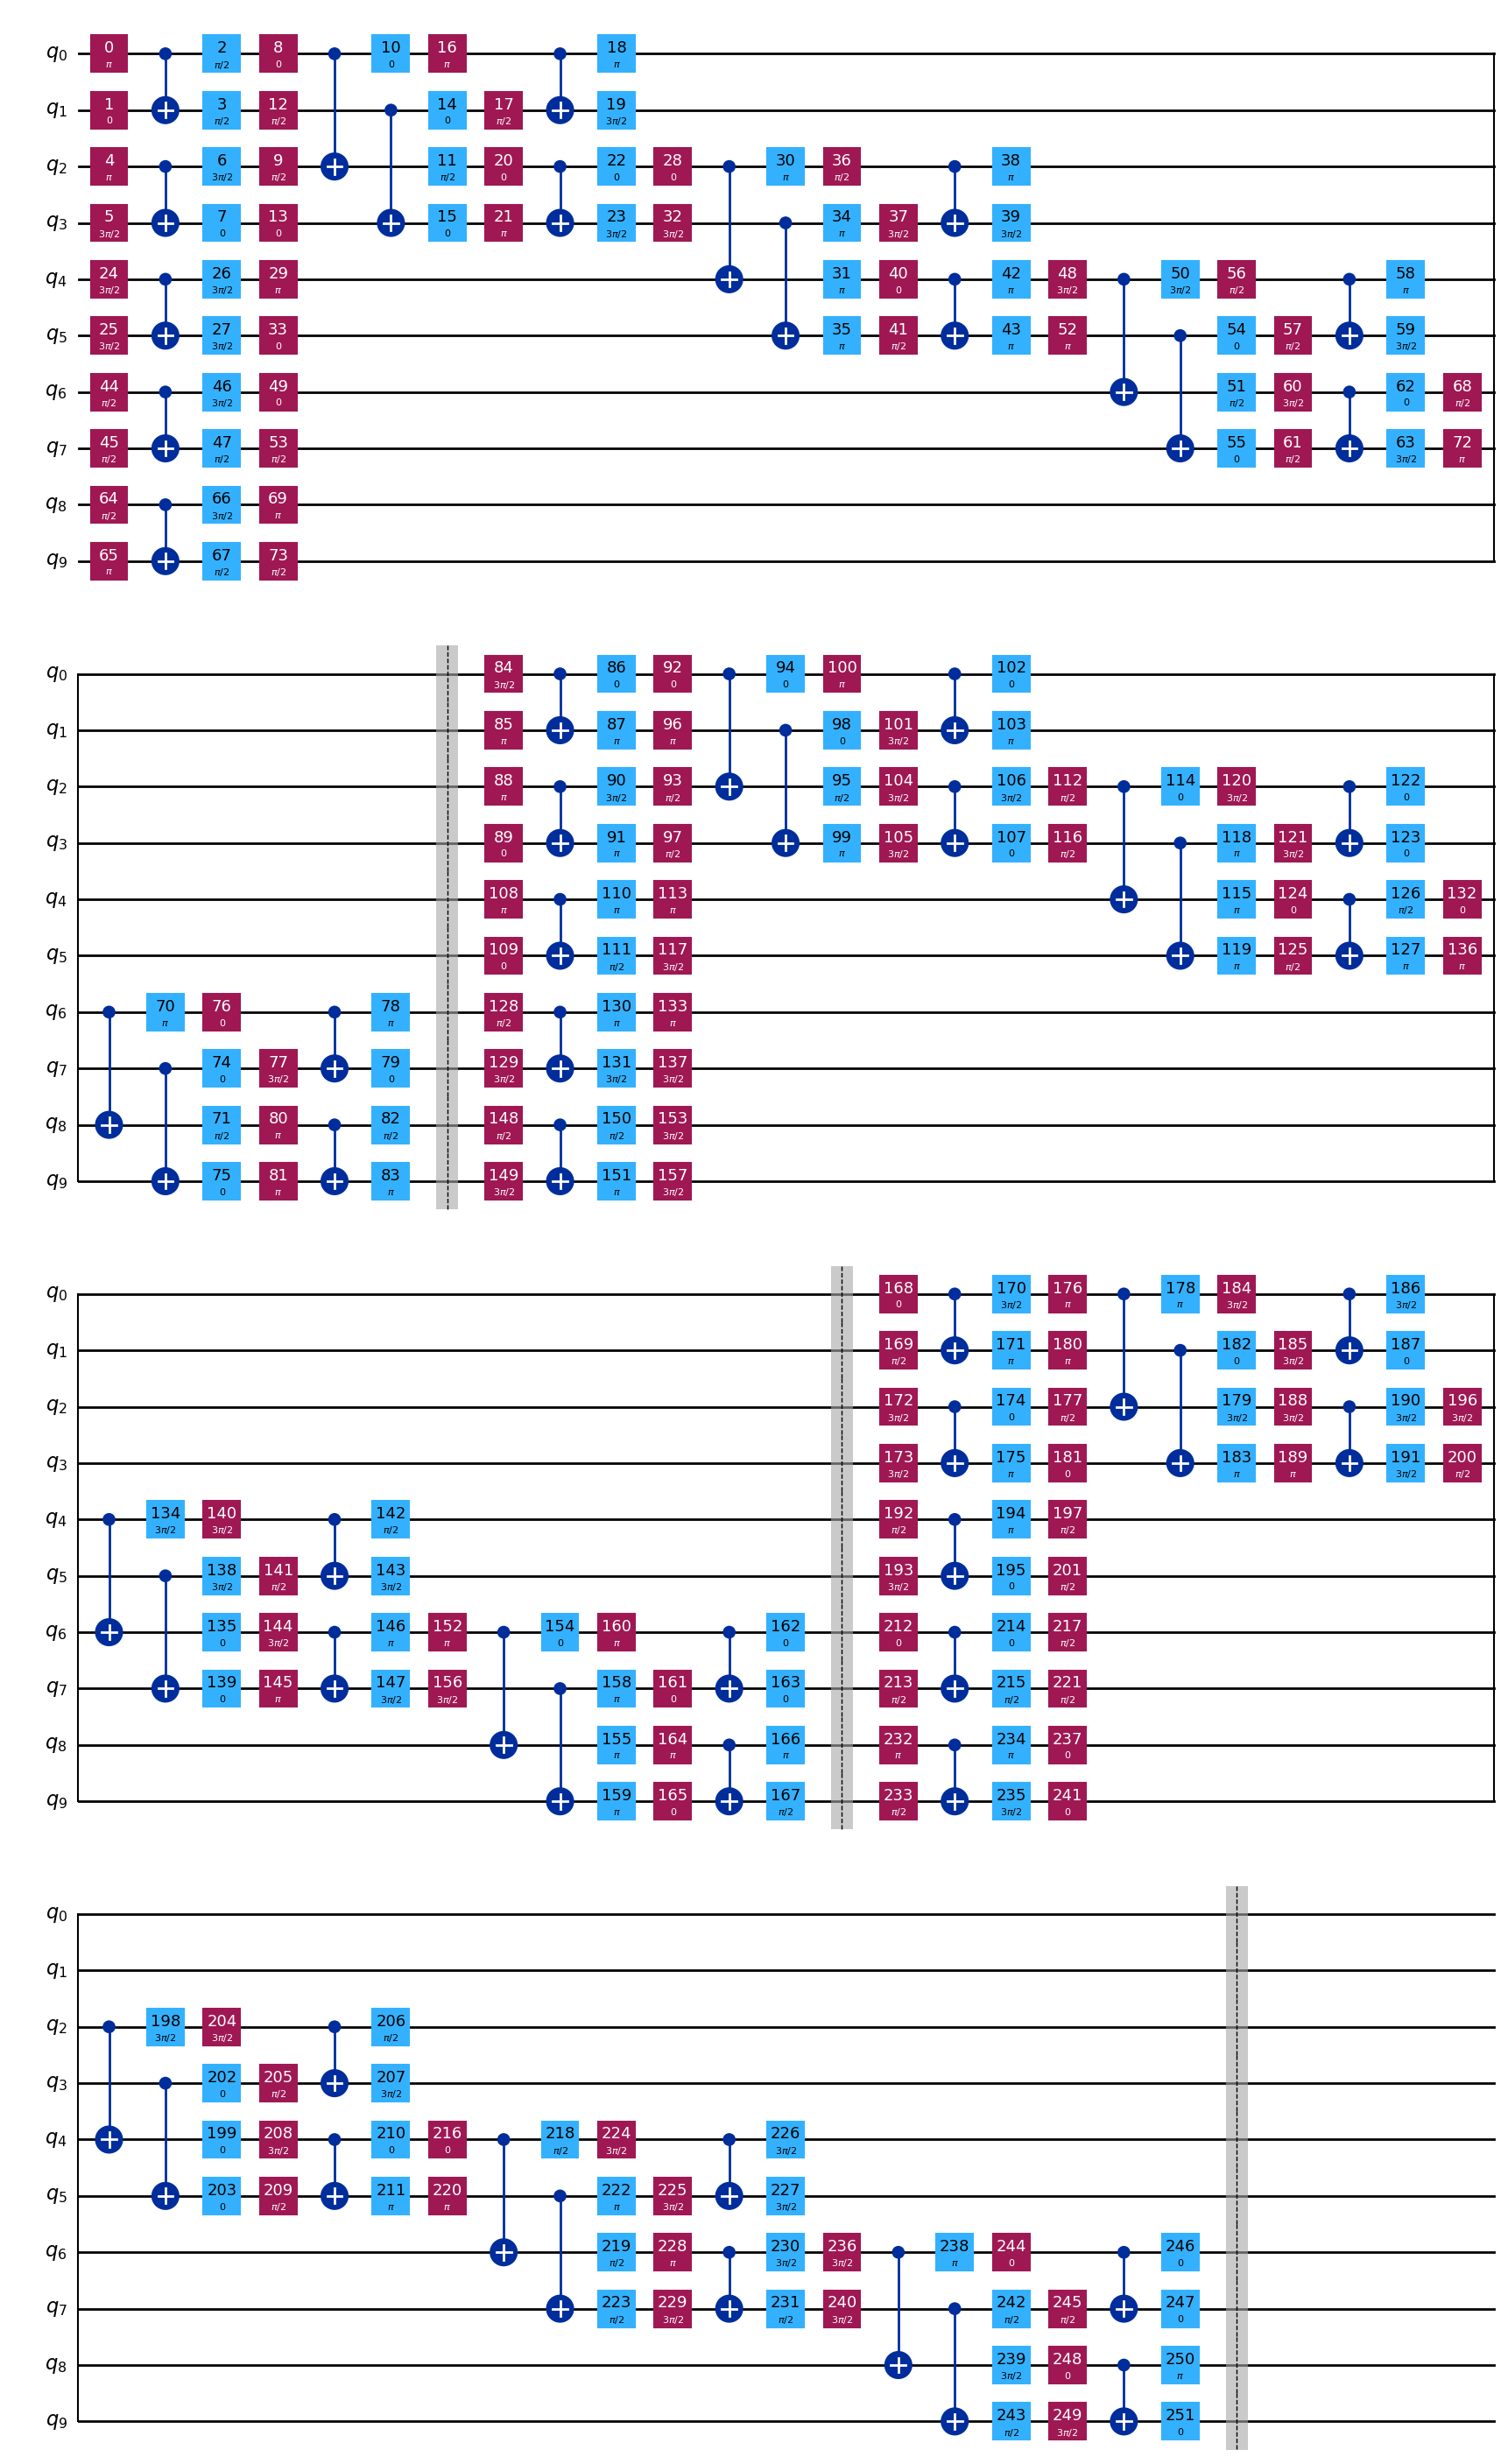

In [82]:
qc.draw("mpl")

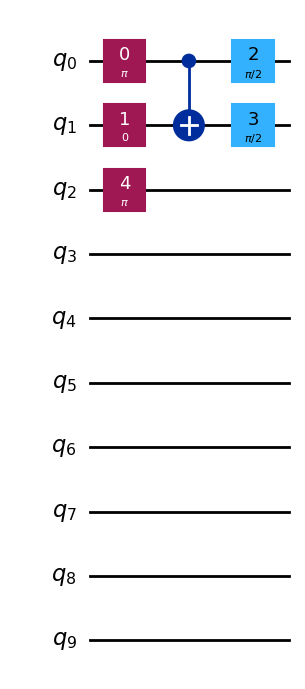

In [88]:
param_circ.cache_heads["5"].draw("mpl")

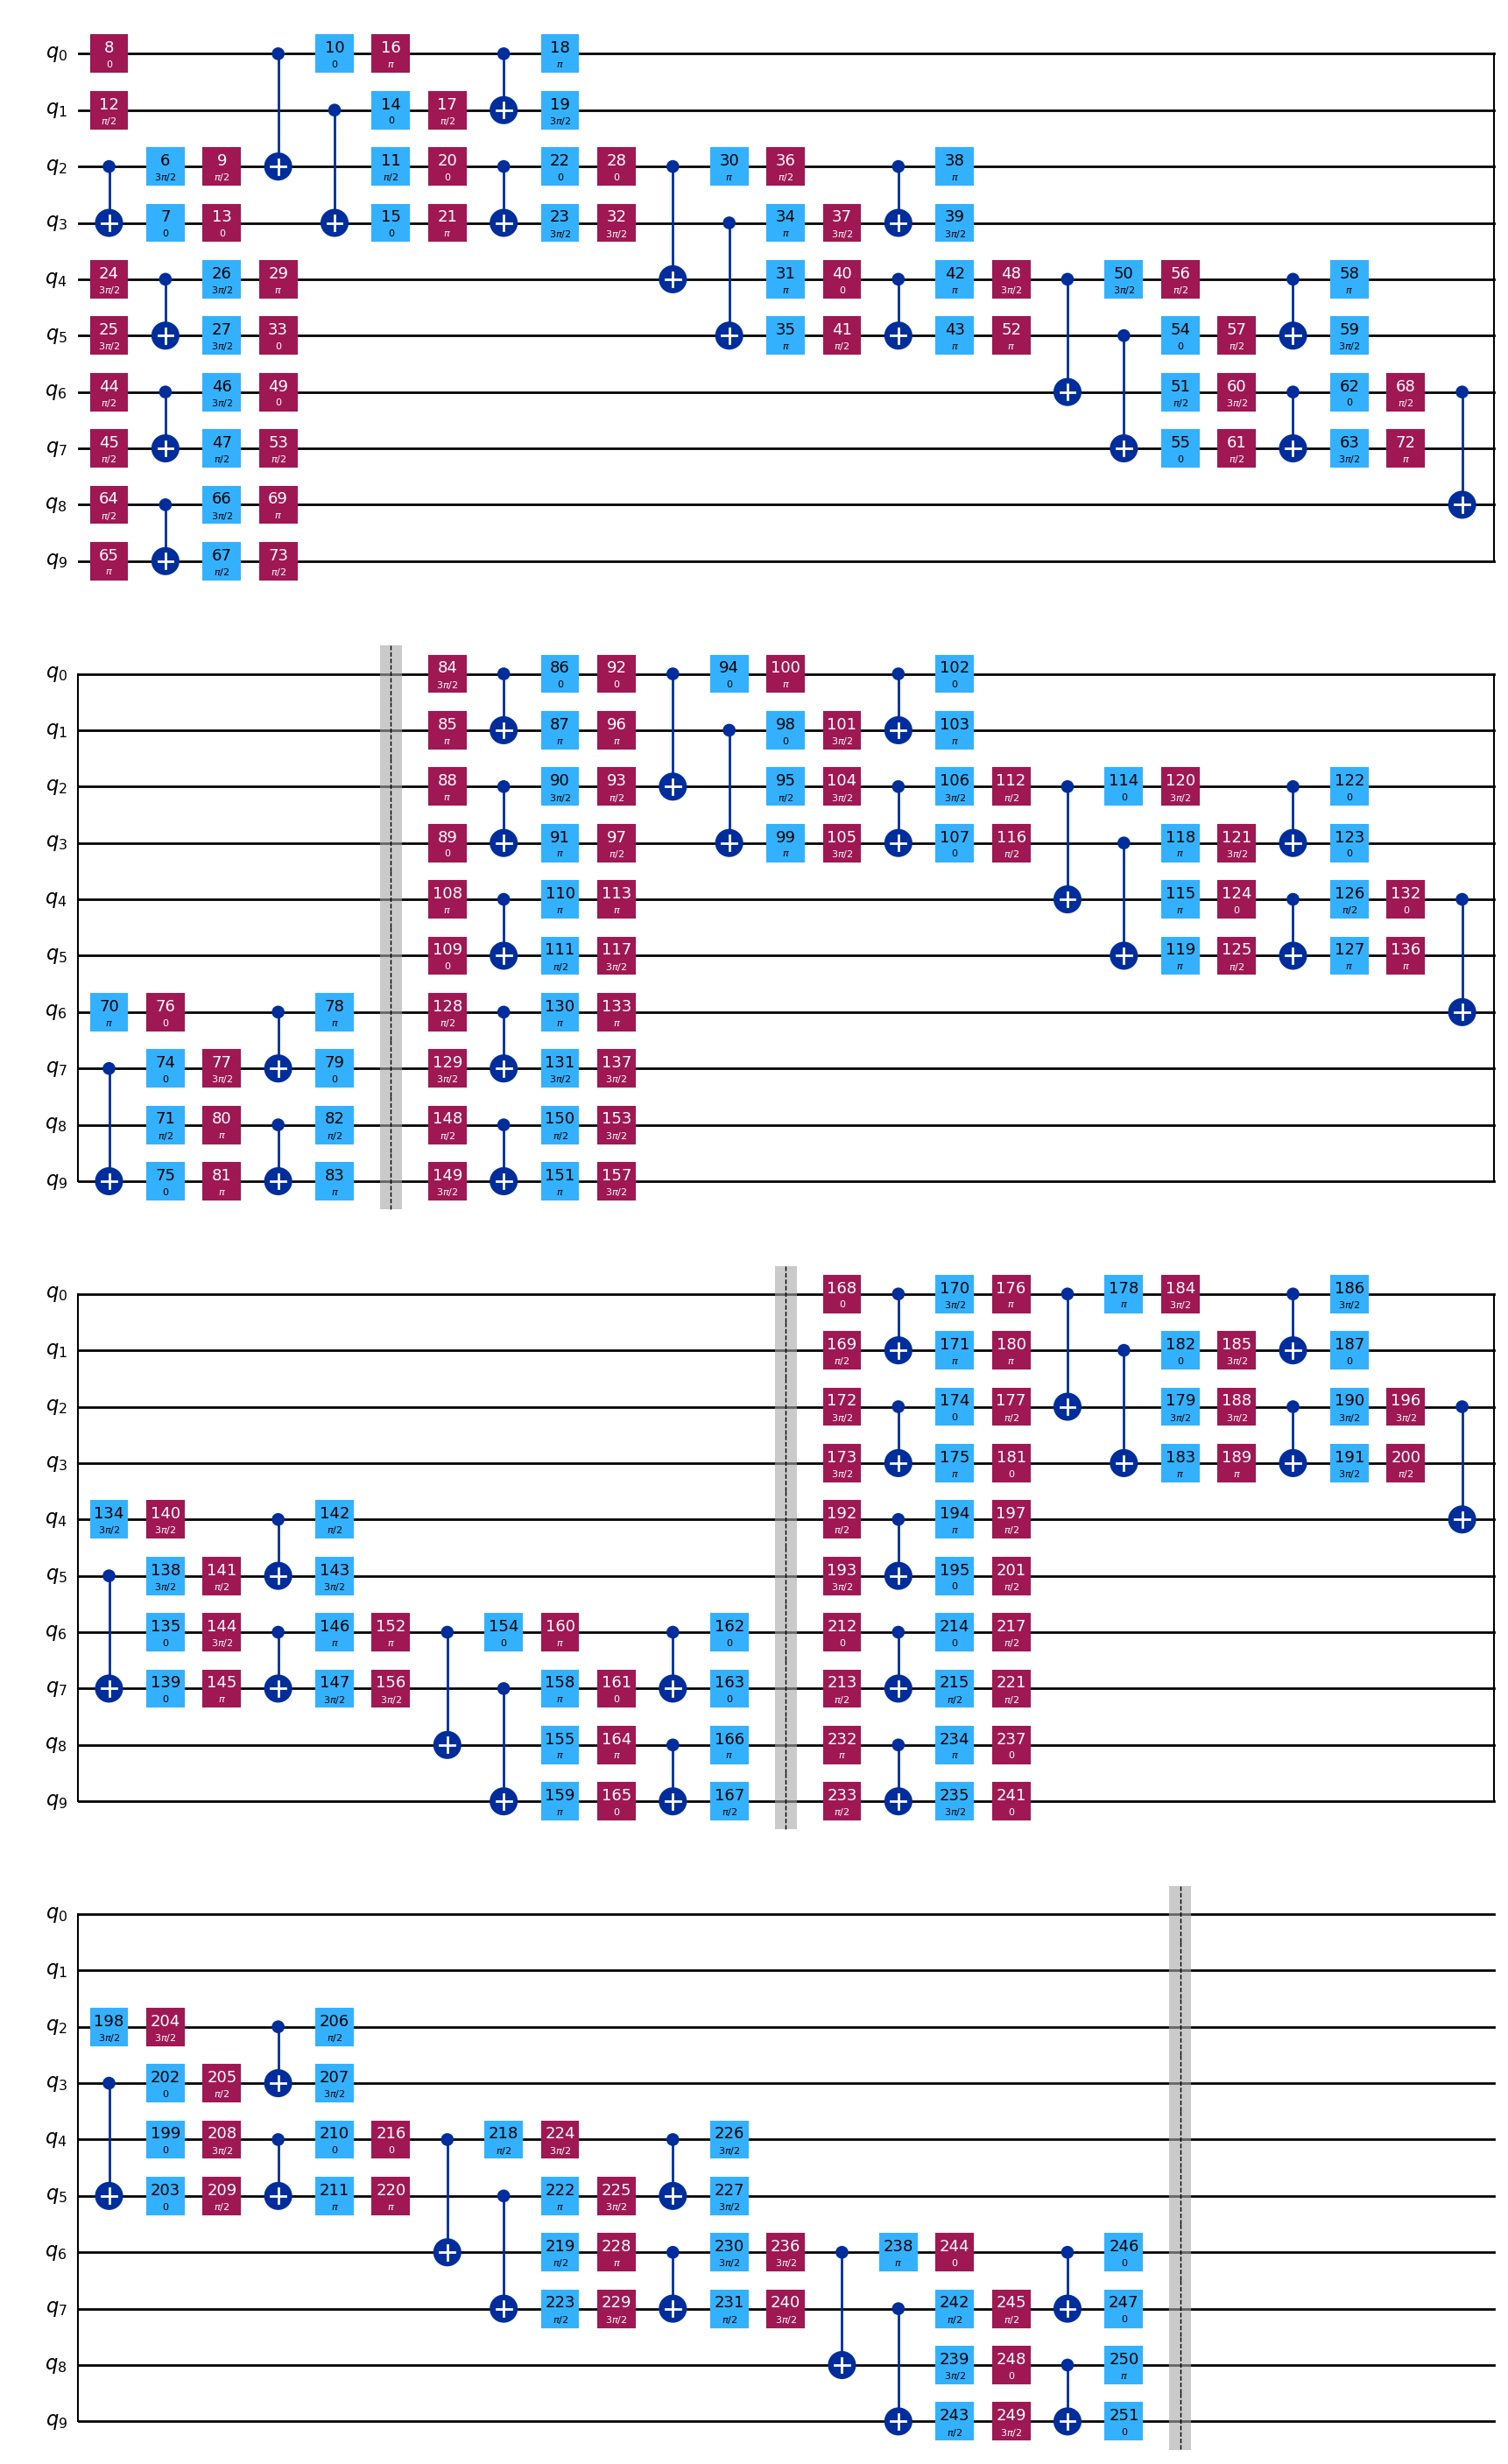

In [89]:
param_circ.cache_tails["5"].draw("mpl")

In [78]:
cutoff = 100



qc_head = qsk.QuantumCircuit(n_qubits)
qc_tail = qsk.QuantumCircuit(n_qubits)
qc_head.data = qc.data[:cutoff]
qc_tail.data = qc.data[cutoff:]

# qc_head = qsk.QuantumCircuit.from_instructions(qc.data[:cutoff], qubits=qc.qubits, clbits= qc.clbits)

# qc_tail = qsk.QuantumCircuit.from_instructions(qc.data[cutoff:], qubits=qc.qubits, clbits= qc.clbits)

print(len(qc_head.data))
print(len(qc_tail.data))
print(len(qc.data))
qc_new = qc_head.compose(qc_tail)
qc_new == qc

100
218
318


True

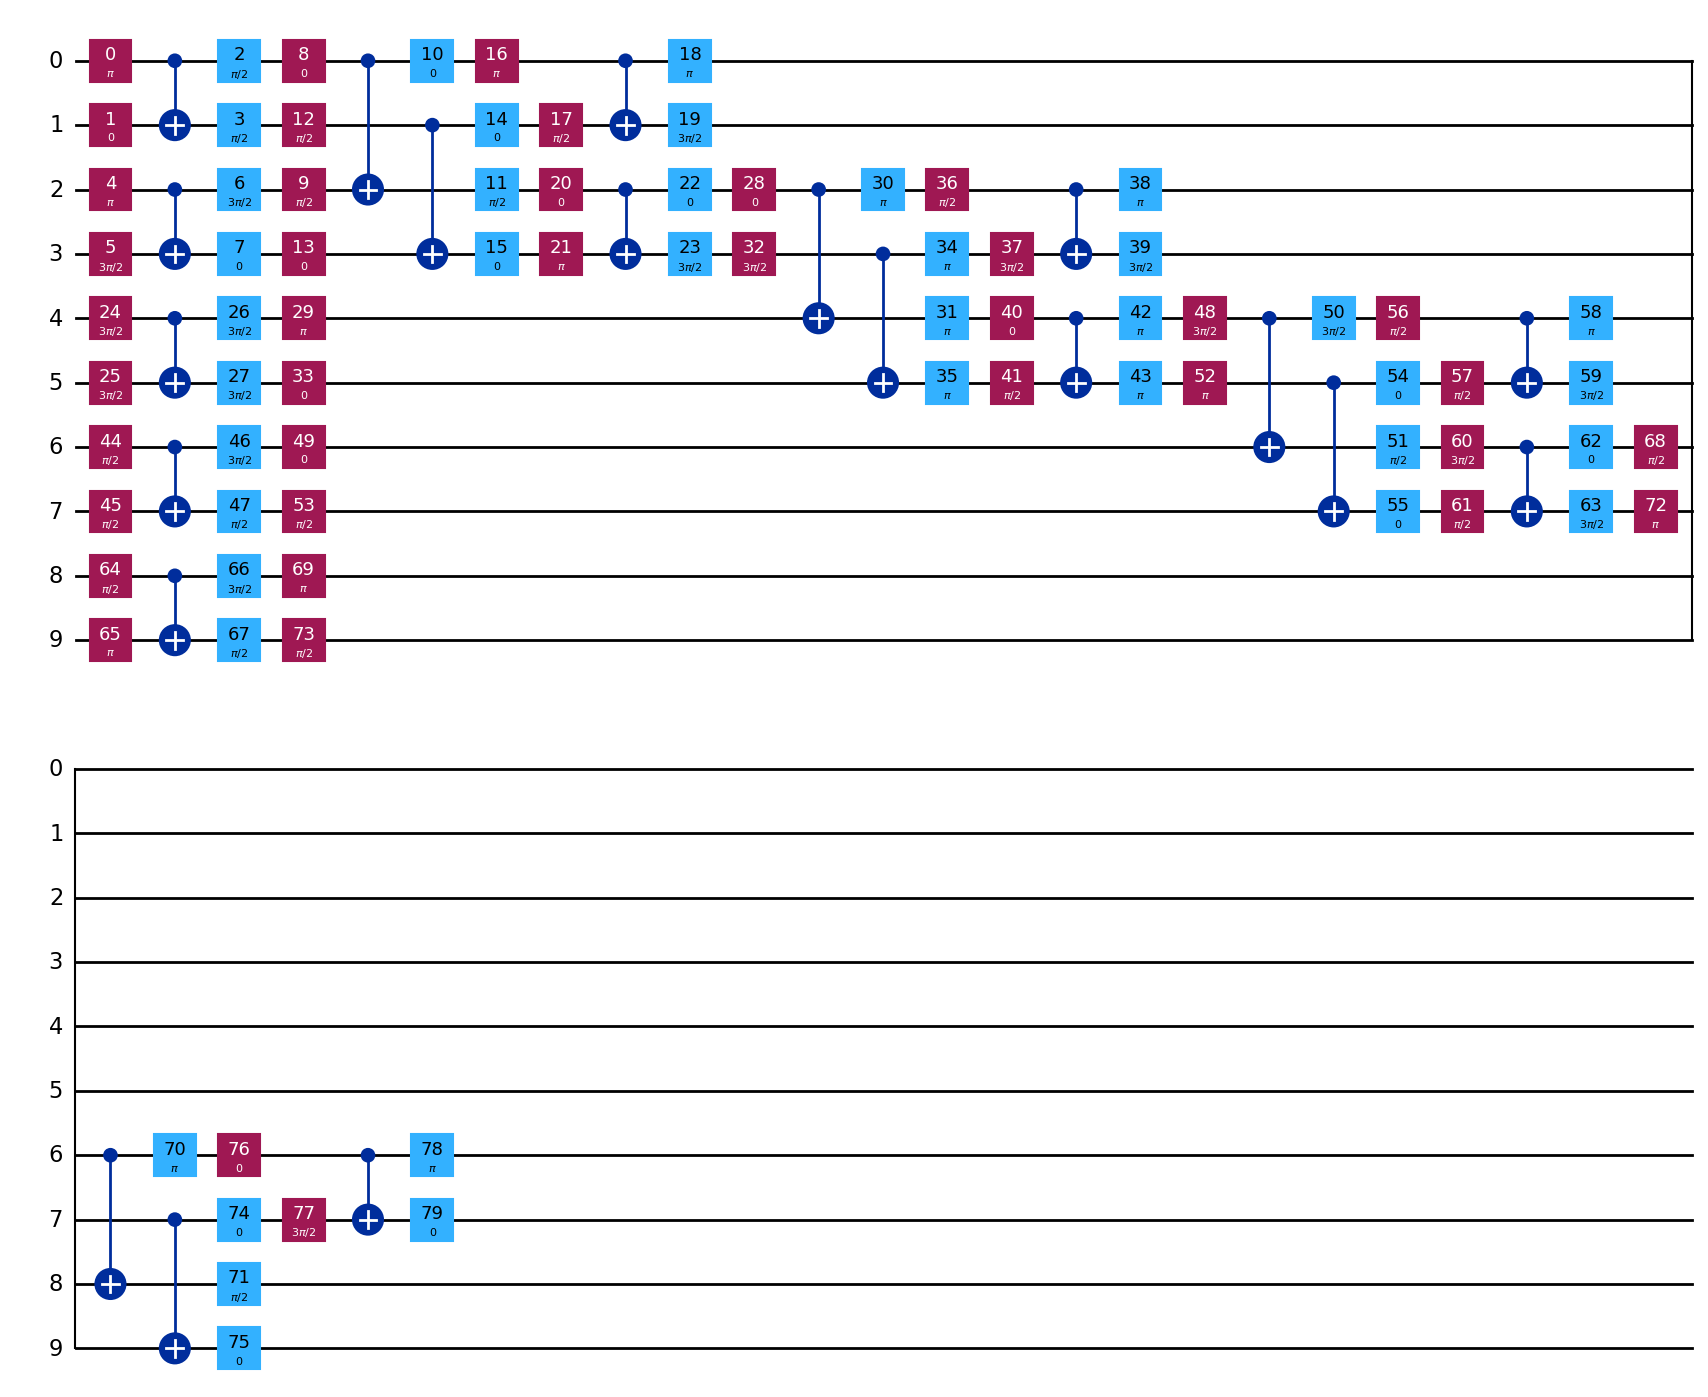

In [51]:
qc_head.draw("mpl")

In [48]:
for instruction in qc.data:
    print(instruction.operation)

Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.141592653589793])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.141592653589793])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[4.71238898038469])
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[4.71238898038469])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.0])


In [49]:
for instruction in qc_head.data:
    print(instruction.operation)

Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.141592653589793])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[3.141592653589793])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[4.71238898038469])
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[4.71238898038469])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[0.0])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.0])


In [42]:
get_index_from_label(qc, "6", starting_index=12)

ValueError: Label 6 not found in circuit

In [116]:
print(len(qc.data))

315


In [5]:
start_time = timer()

tab_test = clifford_RX(2, 0, n_qubits)

end_time = timer()

print(f"Time = {end_time - start_time}")
print(tab_test)

Time = 3.073099992434436e-05
Clifford: Stabilizer = ['-IIIIIIIIIZ', '+IIIIIIIIZI', '+IIIIIIIZII', '+IIIIIIZIII', '+IIIIIZIIII', '+IIIIZIIIII', '+IIIZIIIIII', '+IIZIIIIIII', '+IZIIIIIIII', '+ZIIIIIIIII'], Destabilizer = ['+IIIIIIIIIX', '+IIIIIIIIXI', '+IIIIIIIXII', '+IIIIIIXIII', '+IIIIIXIIII', '+IIIIXIIIII', '+IIIXIIIIII', '+IIXIIIIIII', '+IXIIIIIIII', '+XIIIIIIIII']


In [87]:
tab_test_1 = clifford_RZ(1, 0, n_qubits)
n_shots = 1
start_time = timer()

for _ in range(n_shots): tab_result = tab_test.compose(tab_test_1)
end_time = timer()

print(f"Time = {(end_time - start_time) / n_shots}")

start_time = timer()
for _ in range(n_shots): tab_result1 = Clifford._compose_general(tab_test_1, tab_test)

end_time = timer()

print(f"Time = {(end_time - start_time) / n_shots}")
print(tab_result1 == tab_result)

Time = 0.0005396060005296022
Time = 0.00033275000168941915
True


In [32]:
rand_mat1 = np.array(np.random.randint(0, 1+1, (21, 21)), dtype=bool)
rand_mat2 = np.array(np.random.randint(0, 1+1, (21, 21)), dtype=bool)

start_time = timer()

rand_mat3 = np.dot(rand_mat1, rand_mat2)

end_time = timer()

end_time - start_time

3.5991000004287343e-05